In [43]:
#imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from SPARQLWrapper import SPARQLWrapper, JSON

import json


sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

# 1) DATA LOADING


In [44]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'

#add realase_year 
movie_metadata_df['startYear']= movie_metadata_df['movie_release_date'].str[:4]

#change movie_release_date to pandas datetime
movie_metadata_df['movie_release_date'] = pd.to_datetime(movie_metadata_df['movie_release_date'], format='%Y-%m-%d', errors='coerce')
movie_metadata_df.head(10)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938
8,9997961,/m/06_y2j7,Contigo y aquí,1974-01-01,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",1974
9,2345652,/m/075f66,City of the Dead,1960-01-01,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",1960


In [40]:
#load IMDB reviews
rating_id_df = pd.read_csv('data/rating_id.tsv',  sep='\t')
name_id_df = pd.read_csv('data/name_id.tsv',  sep='\t')
rating_df = pd.merge(rating_id_df, name_id_df, on='tconst')

#drop unnecessary columns 
rating_df.drop(['originalTitle','isAdult','endYear','runtimeMinutes','genres'], axis=1, inplace=True)
rating_df.sample(10)

<ipython-input-40-322c79a2c8c9>:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  name_id_df = pd.read_csv('data/name_id.tsv',  sep='\t')


,tconst,averageRating,numVotes,titleType,movie_name,startYear
1220753,tt6423922,8.2,8,tvEpisode,The Finales,2017
102212,tt0143372,5.4,105,movie,Let's Talk Dirty,1987
1152390,tt5320608,5.0,9,tvMiniSeries,Keiji Ballerino,2016
42673,tt0064549,4.4,28,movie,"Komm nach Wien, ich zeig dir was!",1970
184009,tt0309030,7.2,120,movie,The Death of the Horse,1992
1332878,tt8940028,8.0,10,tvEpisode,A Bridge Too Far,2018
666004,tt14111676,6.7,116,tvEpisode,Dead or Alive,2021
363737,tt0716554,6.1,20,tvEpisode,Arrival of Nancy,1977
352033,tt0690982,6.9,23,tvEpisode,The Train Robbery,1952
1365038,tt9812644,6.2,79,tvMovie,Shattered,2019


In [5]:
#loading the events dataset 
events = pd.read_csv('data/events.csv')
events.head()

,Year,Event Name,Event Description,Event Location,Event Category
0,1820,Missouri Compromise,The Missouri Compromise was a major political ...,United States,Political Events
1,1820,Discovery of Antarctica,"In the year 1820, an extremely significant eve...",Antarctica,Scientific Discoveries and Advancements
2,1820,Cato Street Conspiracy,This event was an attempt to murder all the Br...,United Kingdom,Political Events
3,1820,Comanche Campaign,The Comanche Campaign was a series of military...,United States,Military Conflicts
4,1820,Tom Thumb Engine,The Tom Thumb was the first American-built ste...,United States,Economic Events


In [6]:
#loading the plot summaries dataset and add headers
plot_summaries_df = pd.read_csv('data/plot_summaries.txt', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'plot_summary'])
plot_summaries_df.head(10)

,wiki_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
5,5272176,The president is on his way to give a speech. ...
6,1952976,"{{plot}} The film opens in 1974, as a young gi..."
7,24225279,"The story begins with Hannah, a young Jewish t..."
8,2462689,Infuriated at being told to write one final co...
9,20532852,A line of people drool at the window of the s...


In [7]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 
                        'freebase_character_actor_map_id'])
name_clusters_df.head(10)

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
5,Josh Framm,/m/0jt3p3
6,Josh Framm,/m/0jt3t3
7,Caspian X,/m/0646flc
8,Caspian X,/m/02vd12n
9,Apostle Peter,/m/02vd6_v


In [8]:
#read text file and add headers
character_metadata_df = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id',
                        'freebase_movie_id',
                        'movie_release_date',
                        'character_name',
                        'actor_date_of_birth',
                        'actor_gender',
                        'actor_height',
                        'actor_ethnicity',
                        'actor_name',
                        'actor_age_at_movie_release',
                        'freebase_character_actor_map_id',
                        'freebase_character_id',
                        'freebase_actor_id'])
character_metadata_df.head(10)

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [9]:
#read text file and add headers
tvtropes_clusters_df = pd.read_csv('data/tvtropes.clusters.txt', sep='\t', header=None, names=['character_type', 'data_dict'])
#transform second column to columns
tvtropes_clusters_df['data_dict'] = tvtropes_clusters_df['data_dict'].apply(json.loads)
tvtropes_clusters_df = pd.concat([tvtropes_clusters_df.drop(['data_dict'], axis=1), tvtropes_clusters_df['data_dict'].apply(pd.Series)], axis=1)
#rename columns
tvtropes_clusters_df.columns = ['character_type', 'character_name', 'movie_name', 'freebase_character_actor_map_id', 'actor_name']
tvtropes_clusters_df.head(10)

,character_type,character_name,movie_name,freebase_character_actor_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
5,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford
6,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford
7,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz
9,arrogant_kungfu_guy,Han,Enter the Dragon,/m/02vd8hn,Shih Kien


In [45]:
tvtropes_clusters_df.sample(10)

,character_type,character_name,movie_name,freebase_character_actor_map_id,actor_name
416,romantic_runnerup,Michael Grates,Reality Bites,/m/0k2ct2,Ben Stiller
240,fastest_gun_in_the_west,Ben Wade,3:10 to Yuma,/m/03hqy08,Russell Crowe
177,dirty_cop,Dennis Peck,Internal Affairs,/m/0jzyzv,Richard Gere
91,chanteuse,Dorothy Vallens,Blue Velvet,/m/0jvlc4,Isabella Rossellini
328,junkie_prophet,Agatha,Minority Report,/m/0k0pgt,Samantha Morton
346,loveable_rogue,Wolverine,X-Men,/m/0k86q4,Hugh Jackman
286,grumpy_old_man,Carl Fredricksen,Up,/m/045_cb3,Ed Asner
454,surfer_dude,"Ted ""Theodore"" Logan",Bill & Ted's Excellent Adventure,/m/0jvcqg,Keanu Reeves
41,brainless_beauty,Marcia Brady,The Brady Bunch Movie,/m/0k4k_5,Christine Taylor
133,coward,Carter Burke,Aliens,/m/0jt8n6,Paul Reiser


# 2) MERGING OUR DATA WITH THE IMDB RATINGS DATASET

In [10]:
#merging the movie metadata with the rating data on movie name and release year
movies_ratings = pd.merge(movie_metadata_df, rating_df,  on=['movie_name', 'startYear'])
movies_ratings.shape


(51107, 14)

# 3) CLEANING THE DATA

In [11]:
# printing the types of the merged data 
movies_ratings['titleType'].unique()

array(['movie', 'tvEpisode', 'short', 'tvMovie', 'video', 'tvSeries',
       'videoGame', 'tvMiniSeries', 'tvSpecial', 'tvShort'], dtype=object)

In [12]:
#remove any {{ }} from the plot summary text
plot_summaries_df['plot_summary'] = plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)

In [41]:
# keeping only movies, delete tv episodes, tv movies, video games, etc.
movies_ratings = movies_ratings[movies_ratings['titleType']=='movie']
movies_ratings.sample(20)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,tconst,averageRating,numVotes,titleType
10981,5337946,/m/0dg921,Until September,1984-09-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",1984,tt0088330,5.7,801,movie
13266,20669,/m/0564x,My Neighbor Totoro,1988-04-16,NaN,88.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/03k9fj"":...",1988,tt0096283,8.1,365141,movie
40943,6913417,/m/0gwrzx,Antony and Cleopatra,1972-01-01,NaN,160.0,"{""/m/02h40lc"": ""English Language""}","{""/m/06mzp"": ""Switzerland"", ""/m/06mkj"": ""Spain...","{""/m/04xvh5"": ""Costume drama"", ""/m/07s9rl0"": ""...",1972,tt0068920,5.8,1154,movie
23344,4905605,/m/0cthm5,Roger Dodger,2002-10-25,1934497.0,106.0,"{""/m/04306rv"": ""German Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01t_vv"": ""Comedy-drama"", ""/m/0gsy3b"": ""Se...",2002,tt0299117,6.9,17817,movie
21289,7109992,/m/0h4nbw,Jack London,1943-12-24,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/0219x_"": ""Indie""...",1943,tt0036051,5.1,433,movie
49360,18906833,/m/04jdm_x,John and Julie,1955-07-26,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01t_vv"": ""Comedy-drama"", ""/m/0hj3n26"": ""F...",1955,tt0048231,6.6,277,movie
47688,15057370,/m/0gkt03k,Miss Gold Digger,2007-12-18,NaN,108.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea""}","{""/m/06cvj"": ""Romantic comedy""}",2007,tt1213617,5.6,231,movie
14926,370112,/m/020c39,Gates to Paradise,1968-01-01,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/05qhw"": ""Poland"", ""/m/087vz"": ""Yugoslavia...","{""/m/07s9rl0"": ""Drama""}",1968,tt0062461,6.1,227,movie
36431,3803362,/m/0b0tsc,Blood Bath,1966-01-01,NaN,62.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/0qdzd"": ""B-movie"", ""/...",1966,tt0060174,5.1,1053,movie
44825,37241569,/m/0n53wvj,Cold War,2012-11-08,NaN,NaN,{},"{""/m/0d05w3"": ""China""}","{""/m/02kdv5l"": ""Action""}",2012,tt2186715,6.6,5037,movie


In [14]:
# only keep the movies with more than 100 votes on imdb ratings
movies_ratings = movies_ratings[movies_ratings['numVotes']>200]
movies_ratings.shape

(27739, 14)

In [15]:
#keep movie_metadata_df only with movies that have ratings
movie_metadata_df = movie_metadata_df[movie_metadata_df['freebase_movie_id'].isin(movies_ratings['freebase_movie_id'])]
movie_metadata_df.shape

(27655, 10)

In [16]:
#keep the summaries of the selected movies 
plot_summaries_df = plot_summaries_df[plot_summaries_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]
plot_summaries_df.shape

(20161, 2)

In [17]:
#keep movie_metadata_df only with movies that have summaries
movie_metadata_df = movie_metadata_df[movie_metadata_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]
movie_metadata_df.shape

(20161, 10)

In [18]:
#keep the character_metadata_df only with movies that have summaries and ratings
character_metadata_df = character_metadata_df[character_metadata_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]

In [19]:
#keep the tvtropes_clusters_df only with movies that have summaries and ratings
tvtropes_clusters_df = tvtropes_clusters_df[tvtropes_clusters_df['freebase_character_actor_map_id'].isin(character_metadata_df['freebase_character_actor_map_id'])]

# 2) DATA INSIGHTS

In [20]:
#create a dataframe with only the movie languages
movie_languages_df = movie_metadata_df[['freebase_movie_id', 'movie_languages']]
movie_languages_df['movie_languages'] = movie_metadata_df['movie_languages'].apply(json.loads)
print(movie_languages_df.head(10))
movie_languages_df = movie_languages_df.explode('movie_languages')
movie_languages_df.rename(columns={'movie_languages':'freebase_languages_id'}, inplace=True)
movie_languages_df.head(10)

   freebase_movie_id                                    movie_languages
0          /m/03vyhn                 {'/m/02h40lc': 'English Language'}
4          /m/01mrr1                  {'/m/04306rv': 'German Language'}
13         /m/016ywb                 {'/m/02h40lc': 'English Language'}
17          /m/0kcn7                 {'/m/02h40lc': 'English Language'}
22        /m/05p45cv                                                 {}
29         /m/014k4y                 {'/m/02h40lc': 'English Language'}
31        /m/02pml15                 {'/m/0999q': 'Malayalam Language'}
38        /m/0b6c_nw                                                 {}
47        /m/0b6kc_5                 {'/m/02h40lc': 'English Language'}
49         /m/01mrrd  {'/m/0x82': 'Afrikaans Language', '/m/02h40lc'...


,freebase_movie_id,freebase_languages_id
0,/m/03vyhn,/m/02h40lc
4,/m/01mrr1,/m/04306rv
13,/m/016ywb,/m/02h40lc
17,/m/0kcn7,/m/02h40lc
22,/m/05p45cv,NaN
29,/m/014k4y,/m/02h40lc
31,/m/02pml15,/m/0999q
38,/m/0b6c_nw,NaN
47,/m/0b6kc_5,/m/02h40lc
49,/m/01mrrd,/m/0x82


In [21]:
#create a dataframe with only the movie countries
movie_countries_df = movie_metadata_df[['freebase_movie_id', 'movie_countries']]
movie_countries_df['movie_countries'] = movie_metadata_df['movie_countries'].apply(json.loads)
movie_countries_df = movie_countries_df.explode('movie_countries')
movie_countries_df.rename(columns={'movie_countries':'freebase_countries_id'}, inplace=True)
movie_countries_df.head(10)

,freebase_movie_id,freebase_countries_id
0,/m/03vyhn,/m/09c7w0
4,/m/01mrr1,/m/0345h
13,/m/016ywb,/m/07ssc
17,/m/0kcn7,/m/09c7w0
22,/m/05p45cv,/m/09c7w0
29,/m/014k4y,/m/09c7w0
31,/m/02pml15,/m/03rk0
38,/m/0b6c_nw,/m/0chghy
38,/m/0b6c_nw,/m/0ctw_b
47,/m/0b6kc_5,/m/09c7w0


In [22]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_df['movie_genres'].apply(json.loads)
movie_genres_df = movie_genres_df.explode('movie_genres')
movie_genres_df.rename(columns={'movie_genres':'freebase_genres_id'}, inplace=True)
movie_genres_df.head(10)

,freebase_movie_id,freebase_genres_id
0,/m/03vyhn,/m/01jfsb
0,/m/03vyhn,/m/06n90
0,/m/03vyhn,/m/03npn
0,/m/03vyhn,/m/03k9fj
0,/m/03vyhn,/m/0fdjb
0,/m/03vyhn,/m/02kdv5l
0,/m/03vyhn,/m/09zvmj
4,/m/01mrr1,/m/07s9rl0
13,/m/016ywb,/m/04xvh5
13,/m/016ywb,/m/082gq


In [23]:
#5 biggest box office movies
movie_metadata_df.sort_values(by=['movie_box_office_revenue'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2009
22256,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...",1997
28192,22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...",2012
18645,25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",2011
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",2003


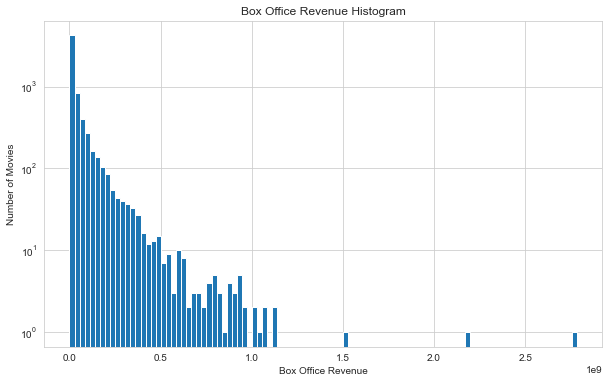

In [24]:
#plot box office revenue with a log scale
plt.figure(figsize=(10, 6))
plt.hist(movie_metadata_df['movie_box_office_revenue'], bins=100, log=True)
plt.xlabel('Box Office Revenue')
plt.ylabel('Number of Movies')
plt.title('Box Office Revenue Histogram')
plt.show()

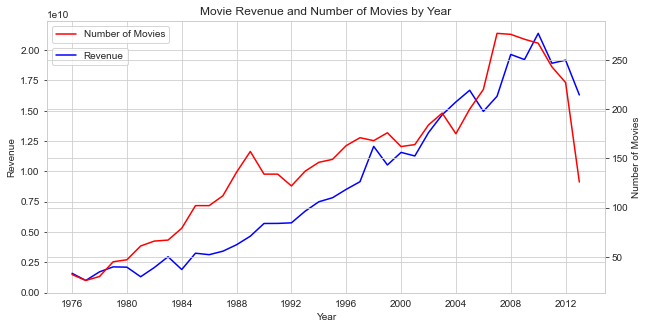

In [25]:
#aggregate movie revenue by year
movie_revenue_by_year = movie_metadata_df.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].sum()
#aggregate number of movies by year ignoring movies with no revenue
movie_with_revenue = movie_metadata_df[movie_metadata_df['movie_box_office_revenue'] > 0]
movie_by_year = movie_with_revenue.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].count()
#plot movie revenue by year
plt.figure(figsize=(10,5))
plt.plot(movie_revenue_by_year.loc['1975':'2012'], color='blue', label='Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.92))
plt.twinx()
plt.plot(movie_by_year.loc['1975':'2012'], color='red', label='Number of Movies')
plt.ylabel('Number of Movies')
plt.title('Movie Revenue and Number of Movies by Year')
plt.legend(loc='upper left')
plt.show()

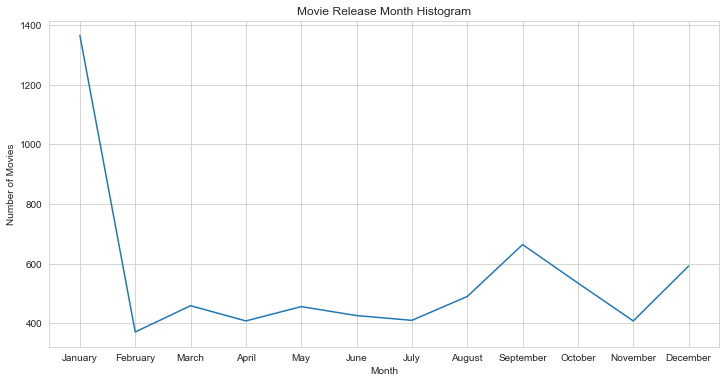

In [26]:
#movies per month ignoring movies with no revenue
movie_per_month = movie_with_revenue.groupby(movie_with_revenue['movie_release_date'].dt.strftime('%m')).count()['freebase_movie_id']
movie_per_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot a histogram of the months with the most movies released
plt.figure(figsize=(12, 6))
plt.plot(movie_per_month)
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.title('Movie Release Month Histogram')
plt.show()

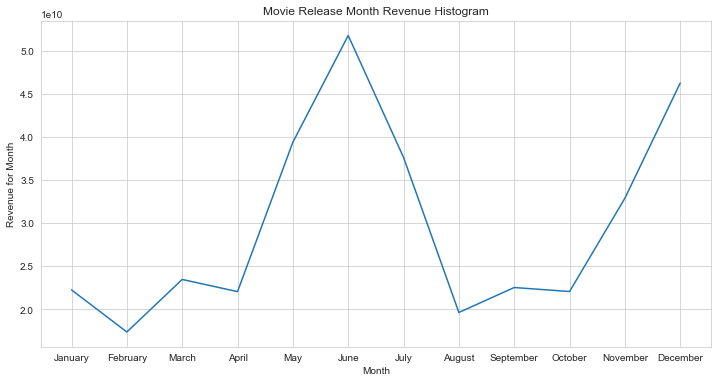

In [27]:
#aggregate movie revenue by month in 12 bins
movie_revenue_by_month = movie_metadata_df.groupby(movie_metadata_df['movie_release_date'].dt.strftime('%m'))['movie_box_office_revenue'].sum()
#change index to month names
movie_revenue_by_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot histogram of movie revenue by month
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month)
plt.xlabel('Month')
plt.ylabel('Revenue for Month')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

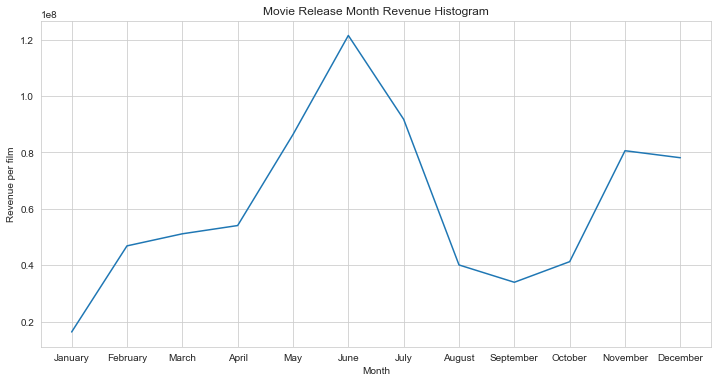

In [28]:
#plot month that are the most profitable
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month/movie_per_month)
plt.xlabel('Month')
plt.ylabel('Revenue per film')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

In [29]:
#5 longest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
57255,2551150,/m/07mjjc,Rebound,2005-07-01,17492014.0,1003.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z02hx"": ""Sports"", ""/m/0hqxf"": ""Family F...",2005
45085,147213,/m/012tj4,Shoah,1985-01-01,NaN,544.0,"{""/m/064_8sq"": ""French Language"", ""/m/03hkp"": ...","{""/m/0f8l9c"": ""France""}","{""/m/03g3w"": ""History"", ""/m/082gq"": ""War film""...",1985
19597,1236676,/m/04l0c9,Empire,1964-01-01,NaN,485.0,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",1964
29772,1236122,/m/04kzqz,Gettysburg,1993-01-01,10769960.0,366.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1993
38295,2384482,/m/0785tk,Bound by Honor,1993-02-05,35000.0,330.0,"{""/m/0jzc"": ""Arabic Language"", ""/m/02h40lc"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1993


In [30]:
#5 longest movies excluding movies longer than 240 minutes (4 hours)
movie_metadata_df[movie_metadata_df['movie_runtime'] < 240].sort_values(by=['movie_runtime'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
20440,417004,/m/025w1d,The Falls,1980-01-01,NaN,239.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/06n90"": ""Science Fiction"", ""/m/0219x_"": ""...",1980
71128,24583717,/m/0807zzf,Love Exposure,2008-11-29,NaN,237.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/02l7c8"": ""Romance Film"", ""/m/02kdv5l"": ""A...",2008
46328,5883015,/m/0fbp9v,The Lost City,1935-03-06,NaN,236.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l...",1935
76622,770242,/m/03b1xy,Flash Gordon Conquers the Universe,1940-03-09,NaN,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",1940
37834,2804704,/m/083skw,Gone with the Wind,1939-12-15,400000000.0,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/060__y"": ""Film adaptation"", ""/m/04xvh5"": ...",1939


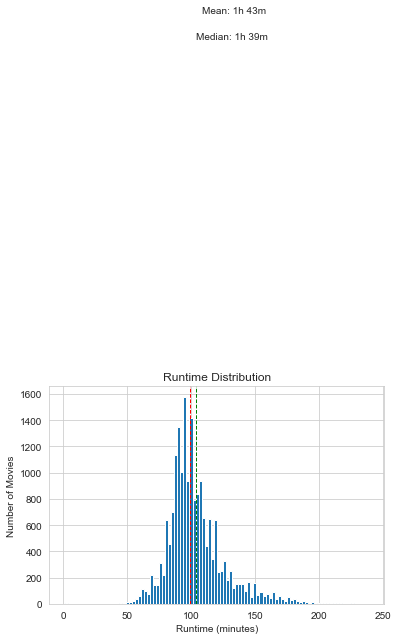

In [31]:
#plot runtime distribution with median and mean
plt.hist(movie_metadata_df[movie_metadata_df['movie_runtime'] < 240]['movie_runtime'], bins=100)
plt.axvline(movie_metadata_df['movie_runtime'].median(), color='red', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].median() + 5, 4300, 'Median: ' + str(int(movie_metadata_df['movie_runtime'].median()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].median()%60)) + 'm')
plt.axvline(movie_metadata_df['movie_runtime'].mean(), color='green', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].mean() + 5, 4500, 'Mean: ' + str(int(movie_metadata_df['movie_runtime'].mean()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].mean()%60)) + 'm')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.title('Runtime Distribution')
plt.show()

In [32]:
#5 shortest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=True).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
54396,2322506,/m/073qxn,Fantastic Planet,1973-12-01,NaN,1.25,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France"", ""/m/01mjq"": ""Czech Rep...","{""/m/02hmvc"": ""Short Film"", ""/m/06n90"": ""Scien...",1973
11762,33994214,/m/0hr6p_4,The King of Pigs,2011-10-08,NaN,1.50,{},"{""/m/06qd3"": ""South Korea""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hcr"": ""Animat...",2011
56639,35025043,/m/0j63_8s,I Love You,2007-01-01,NaN,3.00,{},{},"{""/m/02hmvc"": ""Short Film""}",2007
45815,22816098,/m/0641r9w,Double Identity,2009-01-01,NaN,4.00,{},"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02wtdps"": ""Crime...",2009
78438,5467528,/m/0dn5gt,Our Relations,1936-10-30,NaN,7.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hj3mz5"": ""Com...",1936


In [33]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_series = character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)
actor_ethnicity_series.head(10)

0    /m/044038p
1       /m/0x67
2     /m/064b9n
3    /m/0dryh9k
4     /m/048sp5
5     /m/04mvp8
6     /m/0bzkm2
7    /m/02p1pl6
8    /m/0bjbszh
9     /m/0ffkb4
Name: actor_ethnicity, dtype: object

In [34]:
def get_wikidata_id(freebase_id):
  sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
  query = f"""
  SELECT ?article ?label
  WHERE 
  {{
    ?article schema:about ?item;
        schema:isPartOf <https://en.wikipedia.org/> .
    ?item wdt:P646 "{freebase_id}";
          rdfs:label ?label.
    FILTER(LANG(?label) = "en") # Optional: Filter by English labels
  }}
  """
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  
  try:
      results = sparql.query().convert()
      if 'results' in results and 'bindings' in results['results'] and len(results['results']['bindings']) > 0:
          return results['results']['bindings'][0]['label']['value']
  except Exception as e:
      print(f"Error: {e}")
      time.sleep(20)
      return get_wikidata_id(freebase_id)
  
  return None

In [35]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
transformed_values = [get_wikidata_id(value) for value in actor_ethnicity_series]

Error: HTTP Error 429: Too Many Requests
Error: HTTP Error 429: Too Many Requests


In [36]:
data = {'ethnicity_id': actor_ethnicity_series, 'ethnicity_name': transformed_values}
df = pd.DataFrame(data)
df.head(10)

,ethnicity_id,ethnicity_name
0,/m/044038p,None
1,/m/0x67,African Americans
2,/m/064b9n,Omaha people
3,/m/0dryh9k,Indian person
4,/m/048sp5,Ezhava
5,/m/04mvp8,Malayali
6,/m/0bzkm2,Taiwanese
7,/m/02p1pl6,None
8,/m/0bjbszh,None
9,/m/0ffkb4,Lithuanian American


In [37]:
#characters that have been played by multiple actors
character_metadata_df[character_metadata_df['character_name'].duplicated(keep=False)].sort_values(by=['character_name'])

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
172072,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1950-06-05,M,NaN,NaN,Ronnie Dyson,28.0,/m/0gy_y5r,/m/0h5rdn3,/m/01p27qd
172057,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1945-10-29,F,NaN,/m/0x67,Melba Moore,33.0,/m/0cg6hqj,/m/0h5rdnt,/m/08rgr4
38685,673694,/m/031tc2,1988-08-10,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,26.0,/m/02vcg9t,/m/0h2k5dk,/m/031zkw
29510,675213,/m/031zk3,1990-08-01,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,28.0,/m/02vc4lz,/m/0h2k5dk,/m/031zkw
177246,28370864,/m/0crfcdl,2011-08-12,'Juicy' Judy Gonzalez,1977-03-26,F,1.73,NaN,Bianca Kajlich,34.0,/m/0gvd8fd,/m/0cgm75g,/m/0dlbpj
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450567,22330502,/m/05sync6,1931-01-31,NaN,1889-07-15,F,NaN,NaN,Marjorie Rambeau,NaN,/m/05tg4vt,NaN,/m/079q2l
450584,24997872,/m/09g6klx,2010-05-07,NaN,1972-09-09,M,NaN,/m/01rv7x,Riyaz Khan,37.0,/m/0h888_7,NaN,/m/04645zm
450588,24997872,/m/09g6klx,2010-05-07,NaN,1944-08-01,M,NaN,/m/01rv7x,Delhi Ganesh,65.0,/m/0h6krrl,NaN,/m/04cw5sb
450589,24997872,/m/09g6klx,2010-05-07,NaN,1948-05-22,M,NaN,/m/04mvp8,Nedumudi Venu,61.0,/m/0h7yl4y,NaN,/m/02hkw6


# 4) LARGE REVENUE COORELATION WITH THE IMDB RATINGS

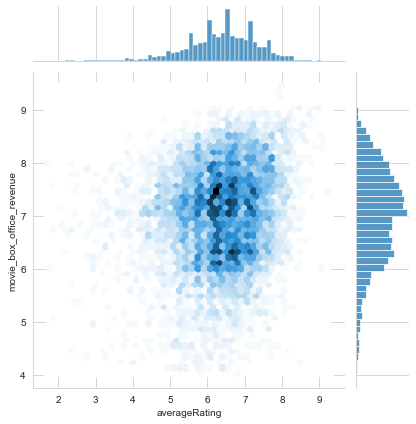

In [38]:
sns.jointplot(x=movies_ratings['averageRating'], y=np.log10(movies_ratings['movie_box_office_revenue']), kind="hex")

In [39]:
# correlation between the average rating and the box office revenue
movies_ratings['averageRating'].corr(movies_ratings['movie_box_office_revenue'])


0.1692386454835258

# 5) Linking events to movies 

In [61]:

print("poportion of data without revenue data: ",movies_ratings['movie_box_office_revenue'].isna().sum()/movies_ratings.shape[0])
print("unique char tropes: ",len(tvtropes_clusters_df['character_type'].unique()))

poportion of data without revenue data:  0.7404737012869966
unique char tropes  72


In [68]:
# create a new dataframe with character_type, actor_name and count columns
df = tvtropes_clusters_df[['character_type', 'actor_name']]
df['count'] = df.groupby(['character_type', 'actor_name'])['actor_name'].transform('count')
df = df.drop_duplicates()
df.sample(70)
df.sort_values(by='count', ascending=False)
df_roles = tvtropes_clusters_df.groupby('actor_name')['character_type'].agg(list).reset_index(name='roles')
df_roles.sample(10)



,actor_name,roles
96,Greg Kinnear,[corrupt_corporate_executive]
297,Tom Berenger,"[drill_sargeant_nasty, psycho_for_hire]"
126,Jean Hagen,"[dumb_blonde, prima_donna]"
315,William H. Macy,[stupid_crooks]
303,Tom Selleck,[gadgeteer_genius]
238,R. Lee Ermey,[drill_sargeant_nasty]
144,John Huston,[corrupt_corporate_executive]
127,Jean Harlow,[dumb_blonde]
6,Alexis Dziena,[brainless_beauty]
230,Peter Facinelli,"[big_man_on_campus, jerk_jock]"
